In [1]:
import squidpy as sq
import scanpy as sc
import scvelo as scv
import numpy as np

In [2]:
adata = sq.datasets.visium_hne_adata()
adata = adata[:,adata.var.highly_variable][:,0:1000].copy()
adata.var.index = np.char.upper(adata.var.index.values.astype(str))
adata.write("./../../test_adata.h5ad")

adata.obs["Cell"] = adata.obs.index
adata.obs[["Cell","cluster"]].to_csv("./../../test_meta.txt", sep="\t", index=False)

adata_df = adata.T.to_df()
adata_df.index.rename("Gene", inplace=True)
adata_df.to_csv("./../../test_adata.txt", sep="\t")

Run the cellphonedb analysis from command line

```
cellphonedb method statistical_analysis test_meta.txt test_adata.txt --output-path="./output" --iterations=1000 --threads=6 --threshold=0.1 --verbose --counts-data hgnc_symbol
```

In [3]:
adata.var

,gene_ids,feature_types,genome,mt,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,n_cells,highly_variable,highly_variable_rank,means,variances,variances_norm
OPRK1,ENSMUSG00000025905,Gene Expression,mm10,False,324,0.171609,0.158378,87.991105,463.0,6.139884,324,True,1577.0,0.172247,0.303405,1.361687
ST18,ENSMUSG00000033740,Gene Expression,mm10,False,415,0.209785,0.190443,84.618236,566.0,6.340359,414,True,1364.0,0.209821,0.389900,1.432583
3110035E14RIK,ENSMUSG00000067879,Gene Expression,mm10,False,1816,3.743514,1.556778,32.690882,10100.0,9.220389,1814,True,223.0,3.756324,41.699811,3.539194
1700034P13RIK,ENSMUSG00000097893,Gene Expression,mm10,False,12,0.005189,0.005176,99.555226,14.0,2.708050,12,True,2418.0,0.005208,0.006672,1.185924
SGK3,ENSMUSG00000025915,Gene Expression,mm10,False,553,0.266123,0.235960,79.503336,718.0,6.577861,553,True,2679.0,0.267113,0.405736,1.148363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TMEM68,ENSMUSG00000028232,Gene Expression,mm10,False,1215,0.759081,0.564791,54.966642,2048.0,7.625107,1215,True,2881.0,0.761905,1.306148,1.126341
PENK,ENSMUSG00000045573,Gene Expression,mm10,False,1364,3.696812,1.546884,49.444033,9974.0,9.207837,1363,True,22.0,3.710193,131.140023,11.358528
FAM110B,ENSMUSG00000049119,Gene Expression,mm10,False,1462,1.007784,0.697031,45.811712,2719.0,7.908387,1462,True,3613.0,1.011533,1.770243,1.064102
SDCBP,ENSMUSG00000028249,Gene Expression,mm10,False,2376,3.751668,1.558496,11.934766,10122.0,9.222566,2373,True,1178.0,3.764509,18.005930,1.522757


In [52]:
res = sq.gr.ligrec(
    adata,
    n_perms=1000,
    cluster_key="cluster",
    copy=True,
    use_raw=False,
    interactions_params={'resources': 'CellPhoneDB'},
    threshold=0.1,
    n_jobs = 6)

In [8]:
adata.obs.cluster.cat.categories

Index(['Cortex_1', 'Cortex_2', 'Cortex_3', 'Cortex_4', 'Cortex_5',
       'Fiber_tract', 'Hippocampus', 'Hypothalamus_1', 'Hypothalamus_2',
       'Lateral_ventricle', 'Pyramidal_layer', 'Pyramidal_layer_dentate_gyrus',
       'Striatum', 'Thalamus_1', 'Thalamus_2'],
      dtype='object')

In [26]:
import re
import os
import pandas as pd
datadir = './../../output'
files = os.listdir(datadir)

class cpdb:
    def __init__(self, datadir):
        files = os.listdir(datadir)
        means = pd.read_csv([datadir +'/'+i for i in files if re.search('^means', i)][0], sep = '\t')
        pvalues = pd.read_csv([datadir +'/'+i for i in files if re.search('^pvalues', i)][0], sep = '\t')
        res2 = {}
        cols = ()
        rows = ()
        for x in means.iloc[:, 11:].columns:
            cols = cols + (tuple(x.split('|')),)
            columns = pd.MultiIndex.from_tuples(cols, names=["cluster_1", "cluster_2"])
        for x in means['interacting_pair']:
            rows = rows + (tuple(x.split('_')),)
        index = pd.MultiIndex.from_tuples(rows, names=["source", "target"])
        means = pd.DataFrame(np.array(means.iloc[:,11:]), index = index, columns = columns)
        pvalues = pd.DataFrame(np.array(pvalues.iloc[:,11:]), index = index, columns = columns)
        pvalues[np.isclose(pvalues, 1.0)] = np.nan
        pvalues[np.isclose(pvalues, 0.0)] = 0.001 # since i only did 1k iterations
        self.means = means
        self.pvalues = pvalues

def CellPhoneResults(datadirs):
    return(cpdb(datadirs).__dict__)

In [48]:
original_cpdb_results = CellPhoneResults(datadir)

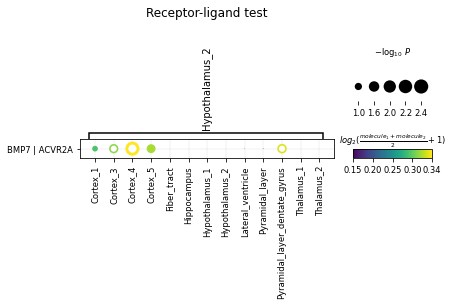

In [49]:
sq.pl.ligrec(res, source_groups="Hypothalamus_2", alpha=0.05)

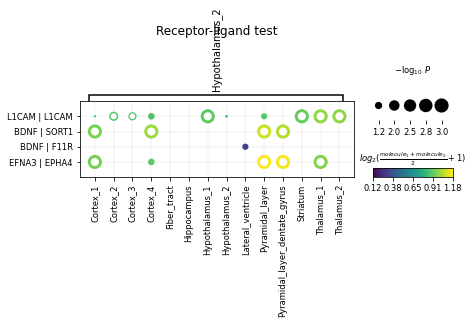

In [50]:
sq.pl.ligrec(original_cpdb_results, source_groups="Hypothalamus_2", alpha=0.05)

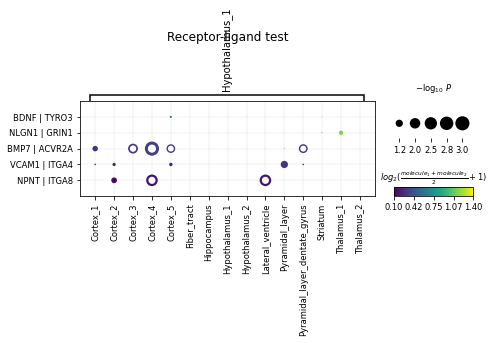

In [43]:
sq.pl.ligrec(res, source_groups="Hypothalamus_1", alpha=0.05,)

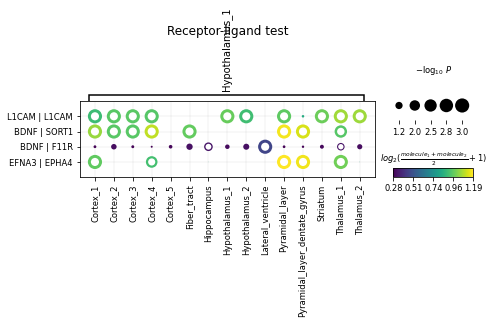

In [42]:
sq.pl.ligrec(original_cpdb_results, source_groups="Hypothalamus_1", alpha=0.05)

In [51]:
res["means"]

cluster_1      Cortex_1                                                      \
cluster_2      Cortex_1  Cortex_2  Cortex_3  Cortex_4  Cortex_5 Fiber_tract   
source target                                                                 
NPPC   NPR1    0.121109  0.130683  0.121975  0.124185  0.131934    0.166381   
QRFP   QRFPR   0.000000  0.000000  0.000000  0.000000  0.000000    0.000000   
BMP7   ACVR2A  0.213889  0.356070  0.231769  0.260584  0.238752    0.103640   
IL7    IL2RG   0.009020  0.005502  0.008354  0.006813  0.016460    0.010901   

cluster_1                                                                  \
cluster_2     Hippocampus Hypothalamus_1 Hypothalamus_2 Lateral_ventricle   
source target                                                               
NPPC   NPR1      0.127520       0.130540       0.148737          0.197150   
QRFP   QRFPR     0.000000       0.000000       0.000000          0.000000   
BMP7   ACVR2A    0.106134       0.161225       0.122098          0.163308   
IL7    IL2RG     0.004781       0.009324       0.012746          0.043537   

cluster_1      ...  Thalamus_2                                            \
cluster_2      ... Fiber_tract Hippocampus Hypothalamus_1 Hypothalamus_2   
source target  ...                                                         
NPPC   NPR1    ...    0.122519    0.083657       0.086677       0.104875   
QRFP   QRFPR   ...    0.000000    0.000000       0.000000       0.000000   
BMP7   ACVR2A  ...    0.106876    0.109369       0.164460       0.125334   
IL7    IL2RG   ...    0.016486    0.010366       0.014909       0.018330   

cluster_1                                                                      \
cluster_2     Lateral_ventricle Pyramidal_layer Pyramidal_layer_dentate_gyrus   
source target                                                                   
NPPC   NPR1            0.153287        0.109735                      0.143877   
QRFP   QRFPR           0.000000        0.000000                      0.000000   
BMP7   ACVR2A          0.166543        0.156306                      0.254942   
IL7    IL2RG           0.049122        0.010025                      0.018394   

cluster_1                                      
cluster_2      Striatum Thalamus_1 Thalamus_2  
source target                                  
NPPC   NPR1    0.096979   0.128907   0.100748  
QRFP   QRFPR   0.000000   0.000000   0.000000  
BMP7   ACVR2A  0.293011   0.128185   0.163559  
IL7    IL2RG   0.000000   0.017810   0.018033  

[4 rows x 225 columns]